# something very weird going on with arrays. For some reason, the flattened mask gets applied to the non-flattened data unless a copy is made (copies make sense) OR some weird re-indexing is done (e.g. bar = bar[1:, 1:] wont get rewritten)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import eval_genlaguerre
import time

gvals (array([], dtype=int64),)
0.06975889205932617


/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_44048/969023664.py:177: RuntimeWarning: invalid value encountered in log10
  ax2.contourf(xpix,ypix,np.log10(laguerre.reconstruction),cval,cmap=cm.Greys)


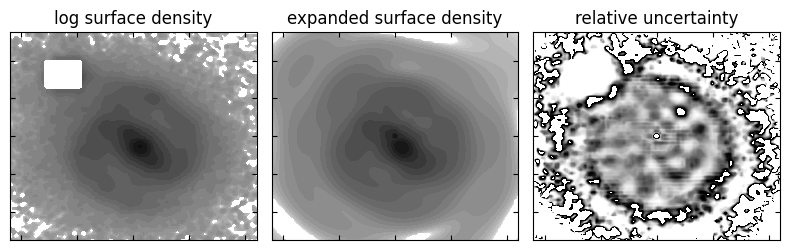

In [198]:
#### from Mike

class LaguerreAmplitudes:
    """
    LaguerreAmplitudes class for calculating Laguerre basis amplitudes.
    This class provides methods for calculating Laguerre basis amplitudes based on Weinberg & Petersen (2021).
    Parameters:
        rscl (float): Scale parameter for the Laguerre basis.
        mass (array-like): Mass values for particles.
        phi (array-like): Angular phi values.
        velocity (array-like): Velocity values.
        R (array-like): Radial values.
        mmax (int): Maximum order parameter for m.
        nmax (int): Maximum order parameter for n.
    Methods:
        gamma_n(nrange, rscl): Calculate the Laguerre alpha=1 normalisation.
        G_n(R, nrange, rscl): Calculate the Laguerre basis.
        n_m(): Calculate the angular normalisation.
        laguerre_amplitudes(): Calculate Laguerre amplitudes for the given parameters.
        laguerre_reconstruction(rr, pp): Calculate Laguerre reconstruction.
    Attributes:
        rscl (float): Scale parameter for the Laguerre basis.
        mass (array-like): Mass values for particles.
        phi (array-like): Angular phi values.
        velocity (array-like): Velocity values.
        R (array-like): Radial values.
        mmax (int): Maximum order parameter for m.
        nmax (int): Maximum order parameter for n.
        coscoefs (array-like): Cosine coefficients.
        sincoefs (array-like): Sine coefficients.
        reconstruction (array-like): Laguerre reconstruction result.
    """

    def __init__(self, rscl, mmax, nmax, R, phi, mass=1., velocity=1.):
        """
        Initialize the LaguerreAmplitudes instance with parameters.
        Args:
            rscl (float): Scale parameter for the Laguerre basis.
            mmax (int): Maximum Fourier harmonic order.
            nmax (int): Maximum Laguerre order.
            R (array-like): Radial values.
            velocity (array-like): Velocity values.
            mass (integer or array-like): Mass values for particles.
            phi (integer or array-like): Angular phi values.
        """
        self.rscl = rscl
        self.mmax = mmax
        self.nmax = nmax
        self.R = R
        self.phi = phi
        self.mass = mass
        self.velocity = velocity


        # run the amplitude calculation
        self.laguerre_amplitudes()

    def _gamma_n(self,nrange, rscl):
        """
        Calculate the Laguerre alpha=1 normalisation.
        Args:
            nrange (array-like): Range of order parameters.
            rscl (float): Scale parameter for the Laguerre basis.
        Returns:
            array-like: Laguerre alpha=1 normalisation values.
        """
        return (rscl / 2.) * np.sqrt(nrange + 1.)

    def _G_n(self,R, nrange, rscl):
        """
        Calculate the Laguerre basis.
        Args:
            R (array-like): Radial values.
            nrange (array-like): Range of order parameters.
            rscl (float): Scale parameter for the Laguerre basis.
        Returns:
            array-like: Laguerre basis values.
        """
        laguerrevalues = np.array([eval_genlaguerre(n, 1, 2 * R / rscl)/self._gamma_n(n, rscl) for n in nrange])
        return np.exp(-R / rscl) * laguerrevalues

    def _n_m(self):
        """
        Calculate the angular normalisation.
        Returns:
            array-like: Angular normalisation values.
        """
        deltam0 = np.zeros(self.mmax)
        deltam0[0] = 1.0
        return np.power((deltam0 + 1) * np.pi / 2., -0.5)

    def laguerre_amplitudes(self):
        """
        Calculate Laguerre amplitudes for the given parameters.
        Returns:
            tuple: Tuple containing the cosine and sine amplitudes.
        """

        G_j = self._G_n(self.R, np.arange(0,self.nmax,1), self.rscl)

        nmvals = self._n_m()
        cosm = np.array([nmvals[m]*np.cos(m*self.phi) for m in np.arange(0,self.mmax,1)])
        sinm = np.array([nmvals[m]*np.sin(m*self.phi) for m in np.arange(0,self.mmax,1)])

        # broadcast to sum values
        self.coscoefs = np.nansum(cosm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.mass * self.velocity,axis=2)
        self.sincoefs = np.nansum(sinm[:, np.newaxis, :] * G_j[np.newaxis, :, :] * self.mass * self.velocity,axis=2)

    def laguerre_reconstruction(self, rr, pp):
        """
        Reconstruct a function using Laguerre amplitudes.
        Args:
            rr (array-like): Radial values.
            pp (array-like): Angular phi values.
        This method reconstructs a function using the Laguerre amplitudes calculated with the `laguerre_amplitudes` method.
        Returns:
            array-like: The reconstructed function values.
        """
        nmvals = self._n_m()
        G_j = self._G_n(rr, np.arange(0, self.nmax, 1), self.rscl)

        fftotal = 0.
        for m in range(0, self.mmax):
            for n in range(0, self.nmax):
                fftotal += self.coscoefs[m, n] * nmvals[m] * np.cos(m * pp) * G_j[n]
                fftotal += self.sincoefs[m, n] * nmvals[m] * np.sin(m * pp) * G_j[n]

        self.reconstruction = 0.5 * fftotal


# load in the data file
snapshot = np.load('CEERSbar1.npy')

# construct the grid for the image
xp = np.linspace(-55.,55.,110)
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
snapshotflat = snapshot.copy().reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>100.) #100
print('gvals',gvals)
rval[gvals]         = np.nan
phi[gvals]          = np.nan
snapshotflat[gvals] = np.nan

# pick orders for the expansion
mmax = 8
nmax = 24

# pick a scalelength for the reconstruction
rscl = 12.


t1 = time.time()
laguerre = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,snapshotflat)

# reconstruct the image at specified grid points (the same as the image points)
laguerre.laguerre_reconstruction(rr,pp)
print(time.time()-t1)



# make a figure for the comparison
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.contourf(xpix,ypix,np.log10(snapshot), cval,cmap=plt.cm.Greys)
ax2.contourf(xpix,ypix,np.log10(laguerre.reconstruction),cval,cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.contourf(xpix,ypix,(laguerre.reconstruction-snapshot)/snapshot,np.linspace(-.25,.25,100),cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')

for ax in [ax1,ax2,ax3]:
    ax.axis([-55,55,-55,55])
    ax.set_xticklabels(())
    ax.set_yticklabels(())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

plt.tight_layout()
plt.savefig('jwst_expansion1.png',dpi=300)

<class 'numpy.ndarray'>


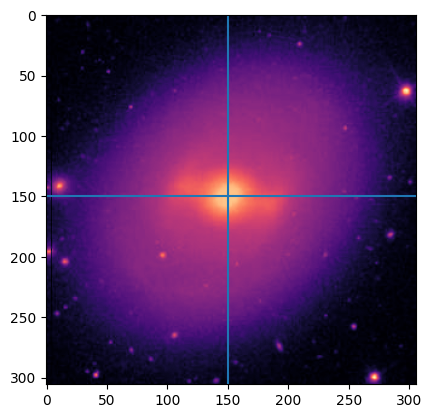

In [199]:
# loading in new figures
from PIL import Image
bar = np.asarray(Image.open('ngc936.jpg'))
print(type(bar))
bar = np.mean(bar, axis=2)
#bar = bar/bar.max()

plt.figure()
plt.imshow(bar[14:,14:], cmap='magma') # not centered -
plt.axvline(150)
plt.axhline(150)

bar = bar[14:,14:]
np.save('bar.npy', bar)

#bar = np.load('bar.npy')

(306, 306) 236.33333333333334
(306, 306) 236.33333333333334
trying r scale of:  10
-4.905760703844593 720.9527126862622 0.3333333333333333 236.33333333333334
trying r scale of:  20
-4.630068406077223 675.6253707341671 0.3333333333333333 236.33333333333334
trying r scale of:  30
-5.229662784758538 513.2699948262278 0.3333333333333333 236.33333333333334
trying r scale of:  40
-4.478695889292326 476.8721236267346 0.3333333333333333 236.33333333333334
trying r scale of:  50
-4.40969722064306 357.1594102450515 0.3333333333333333 236.33333333333334
trying r scale of:  60
-4.479616884762815 395.5363669204255 0.3333333333333333 236.33333333333334
trying r scale of:  70
-5.475500762864922 300.6459131514504 0.3333333333333333 236.33333333333334
trying r scale of:  80
-4.683042983275095 279.51236319400465 0.3333333333333333 236.33333333333334
trying r scale of:  90
-4.989310707576354 289.10622098777293 0.3333333333333333 236.33333333333334
trying r scale of:  100
-5.16550980942946 291.25496210771

/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_44048/44928669.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,3),facecolor='white')


-4.479195745475826 339.5848354310134 0.3333333333333333 236.33333333333334
trying r scale of:  120
-4.582034009355376 334.1728421525925 0.3333333333333333 236.33333333333334
trying r scale of:  130
-5.1535745726926425 288.5956543014574 0.3333333333333333 236.33333333333334
trying r scale of:  140
-5.225475866100863 232.64574869978807 0.3333333333333333 236.33333333333334
trying r scale of:  150
-4.795790299516057 214.18944563914735 0.3333333333333333 236.33333333333334
trying r scale of:  160
-4.339992019431869 215.4441124239488 0.3333333333333333 236.33333333333334
trying r scale of:  170
-4.2607406578108495 222.61170264357102 0.3333333333333333 236.33333333333334
trying r scale of:  180
-4.5624614309297105 239.42982981509257 0.3333333333333333 236.33333333333334
trying r scale of:  190
-4.965186068629278 257.31890673909857 0.3333333333333333 236.33333333333334
trying r scale of:  200
-5.233216717712364 273.58174961617 0.3333333333333333 236.33333333333334


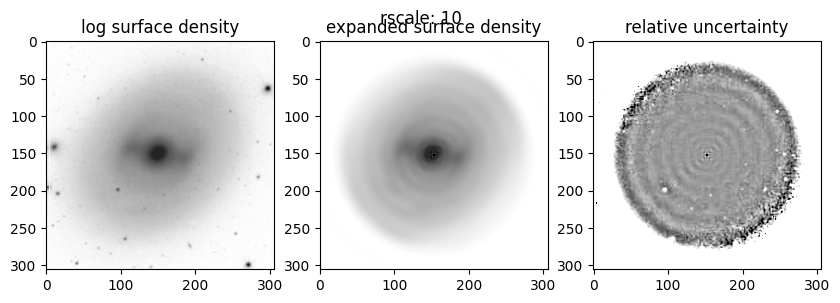

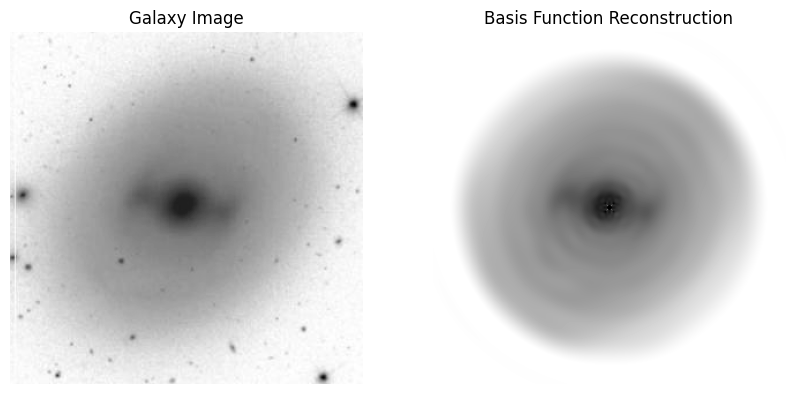

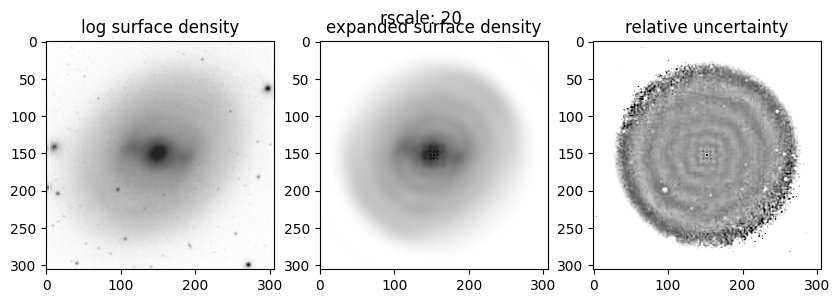

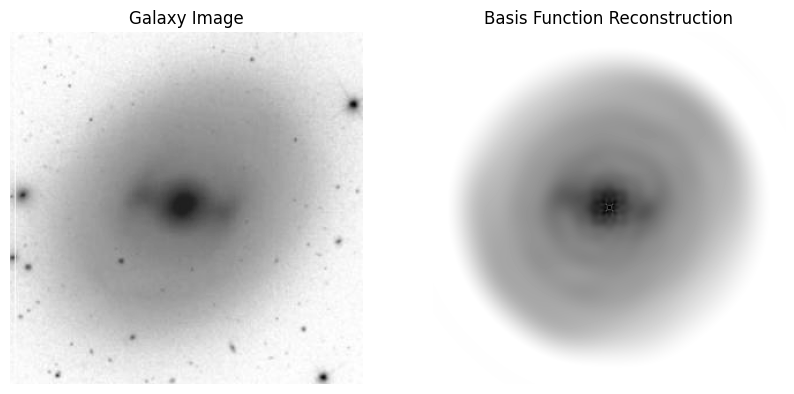

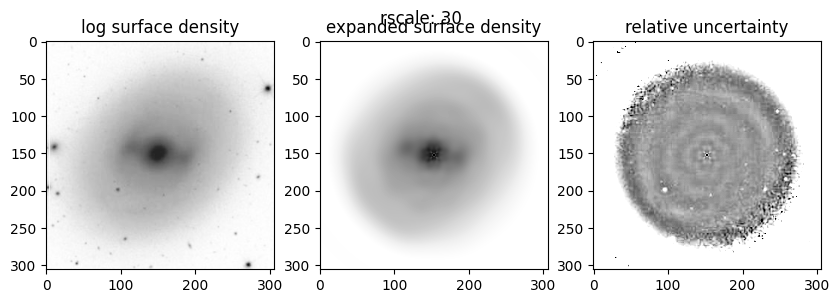

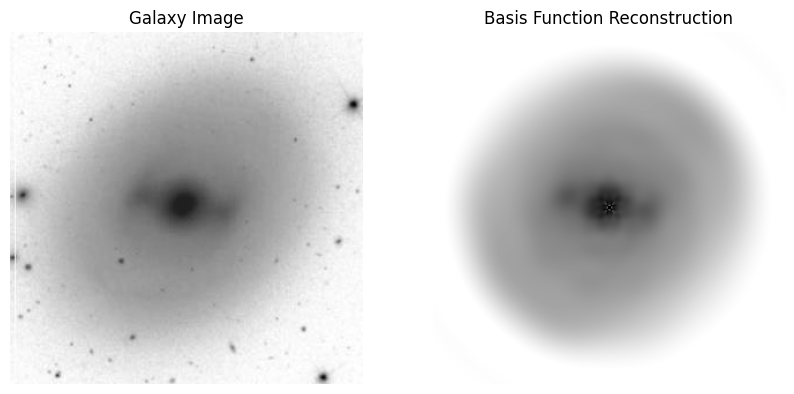

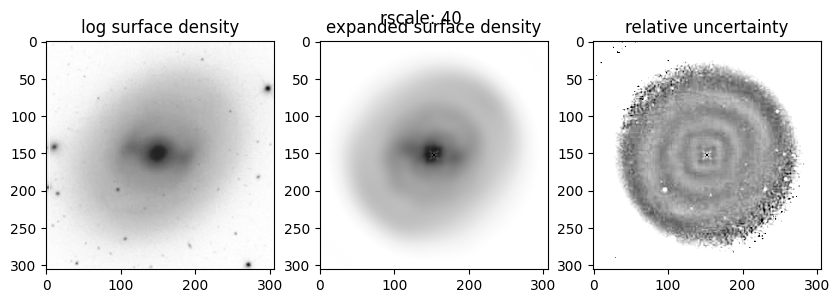

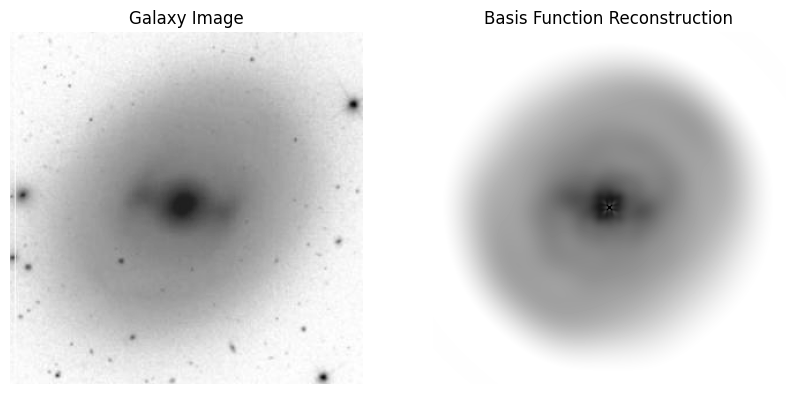

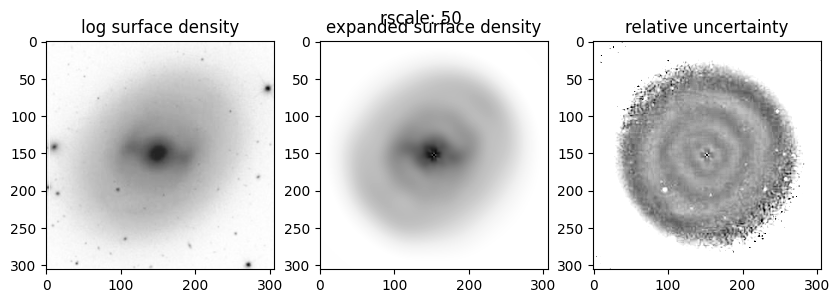

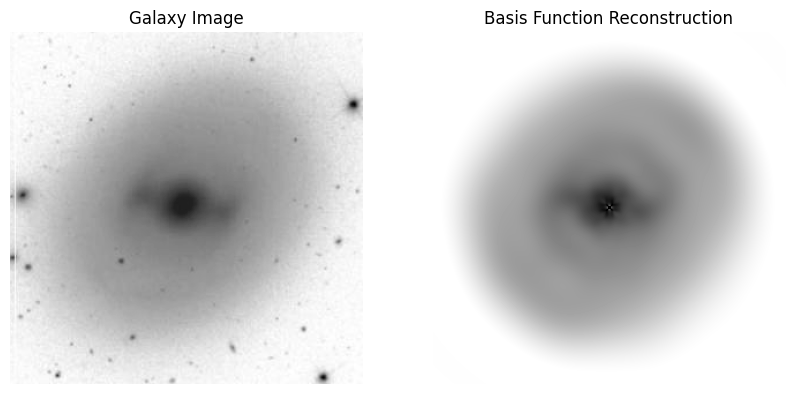

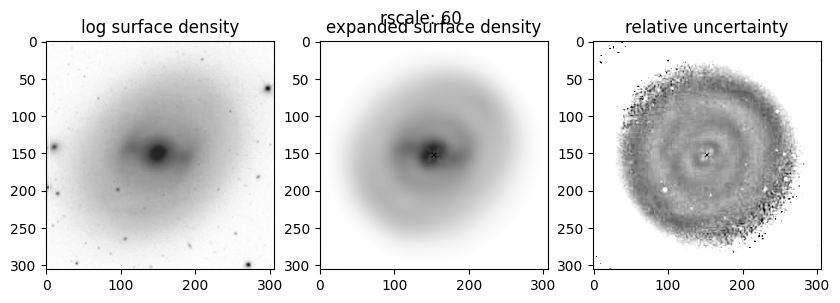

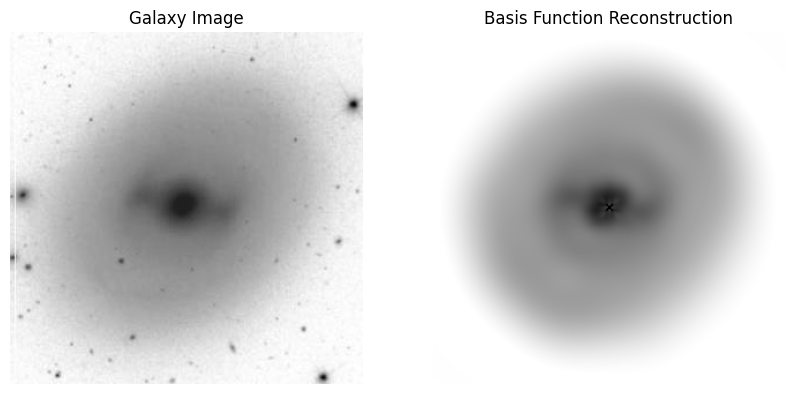

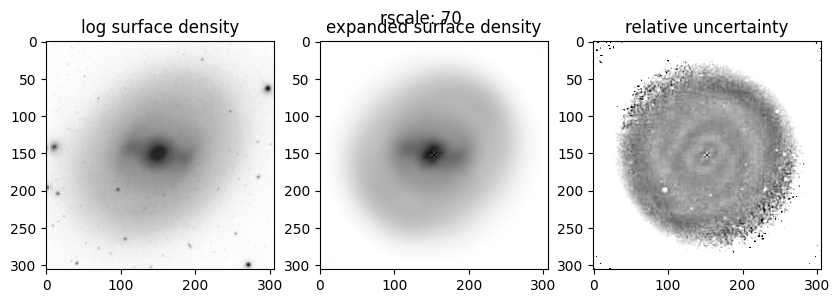

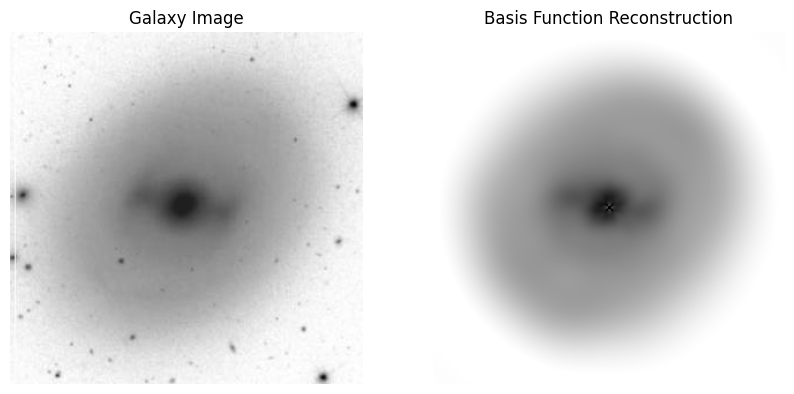

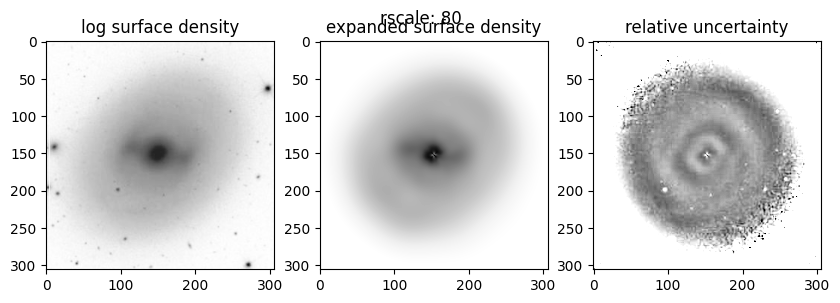

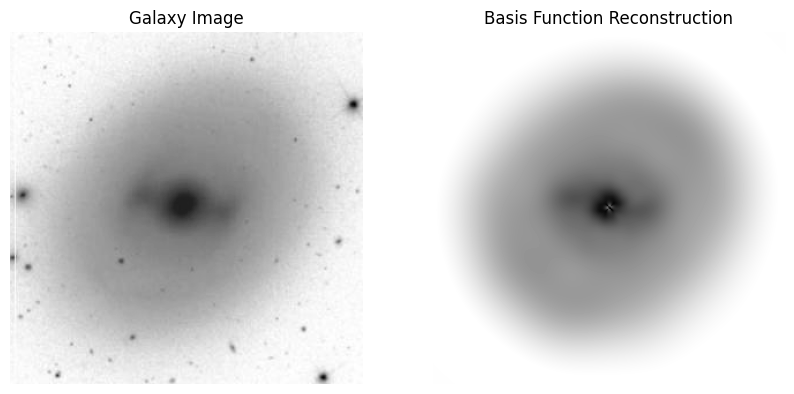

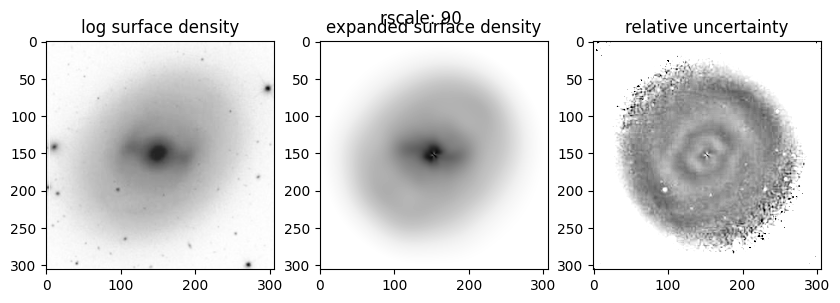

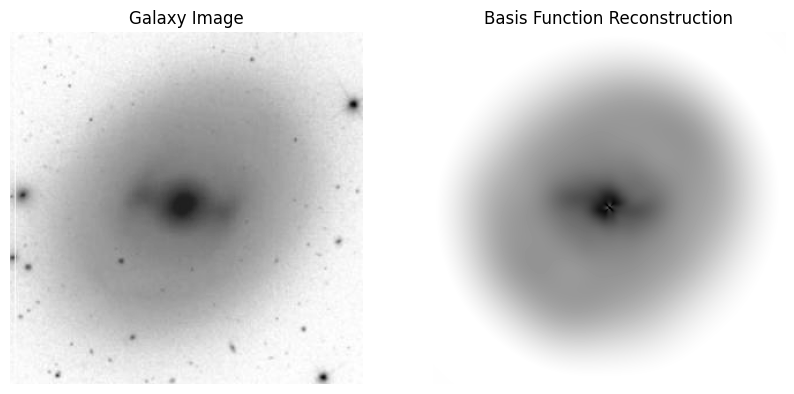

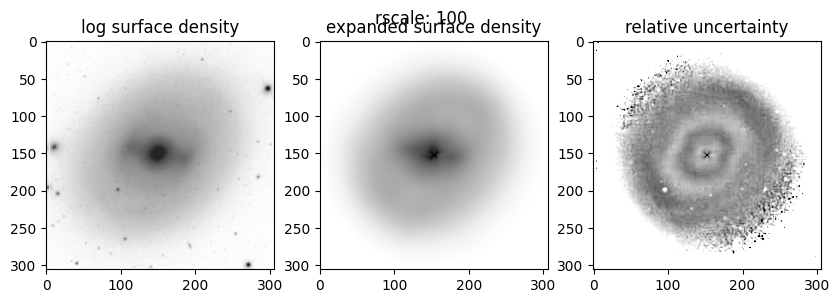

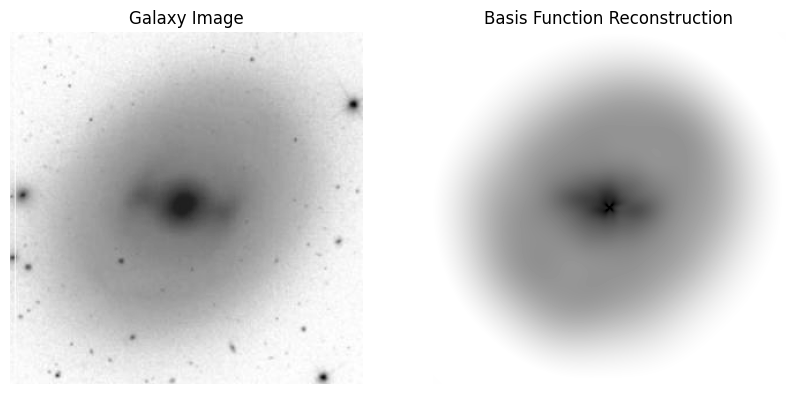

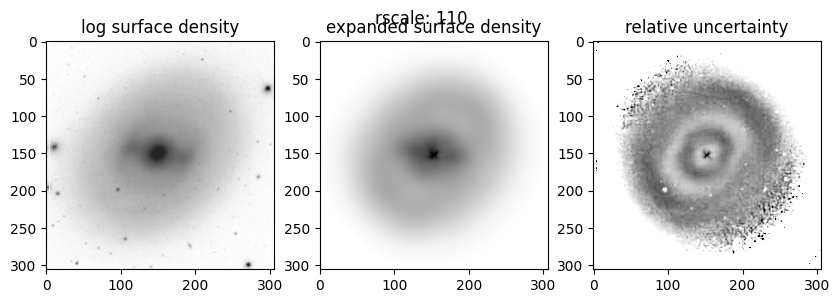

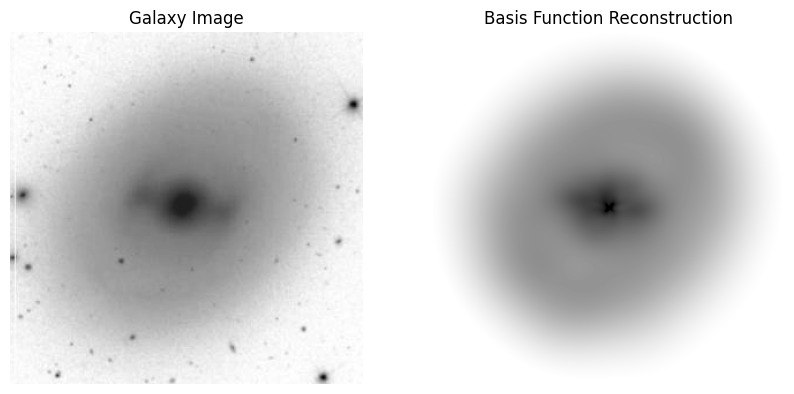

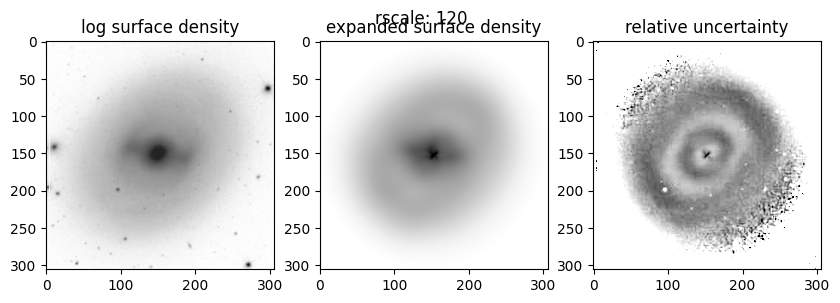

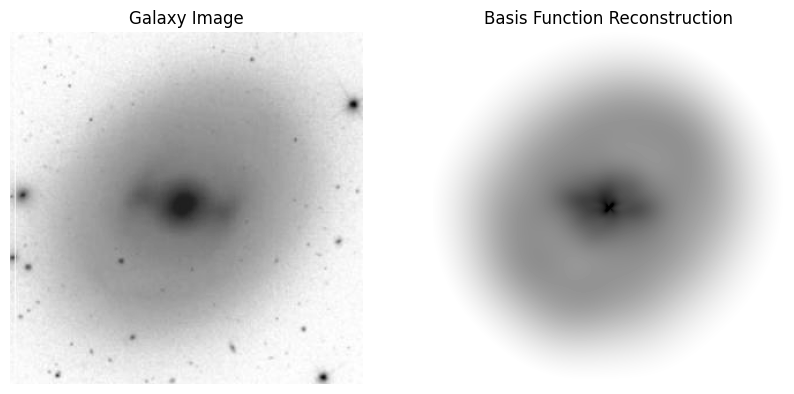

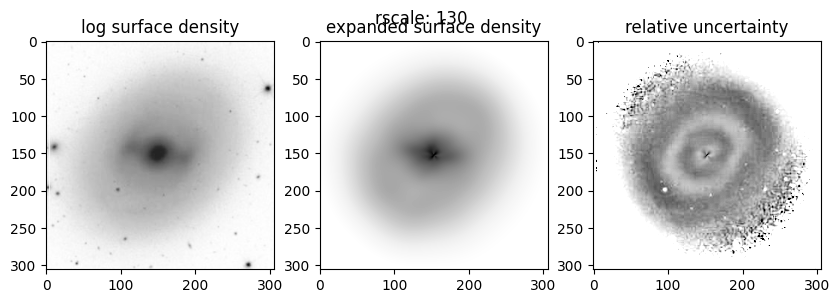

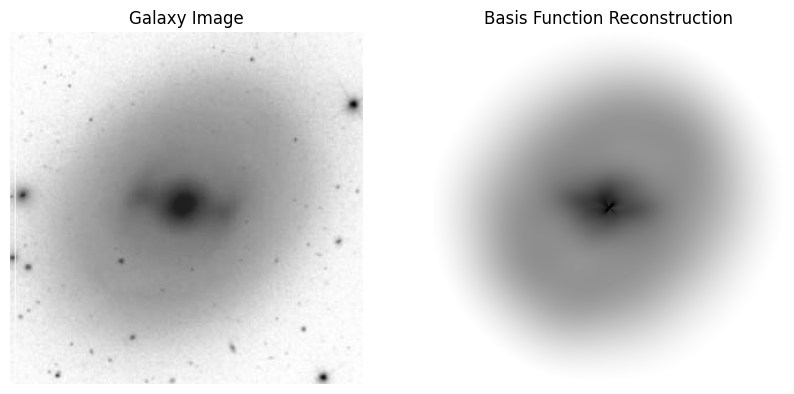

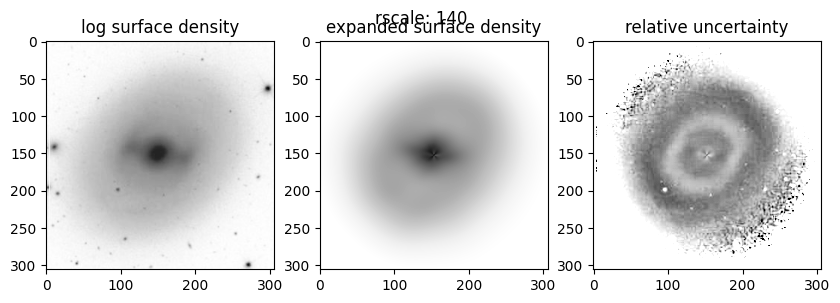

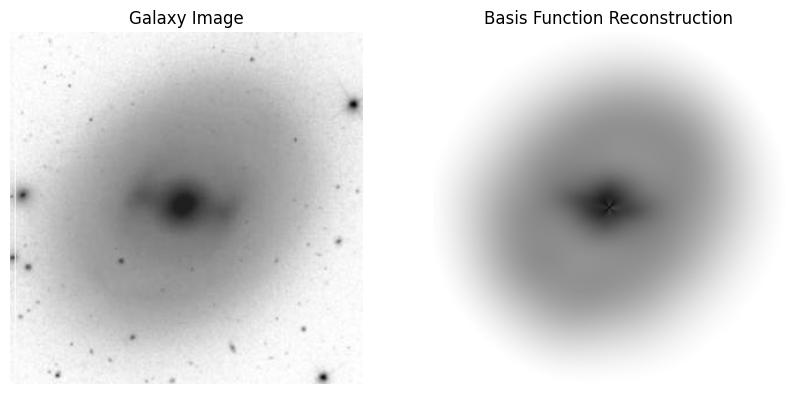

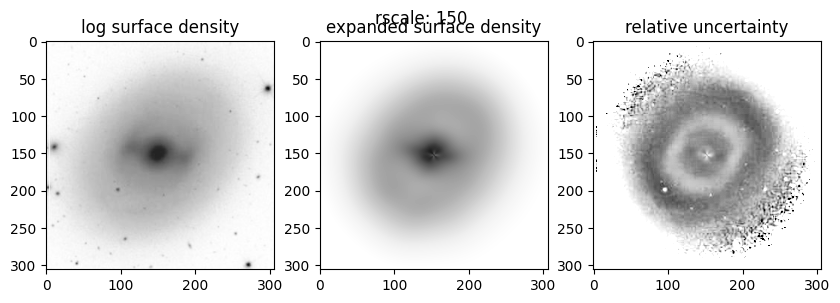

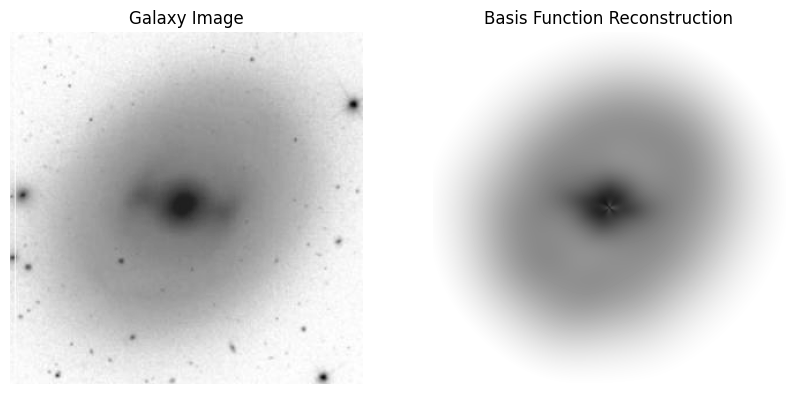

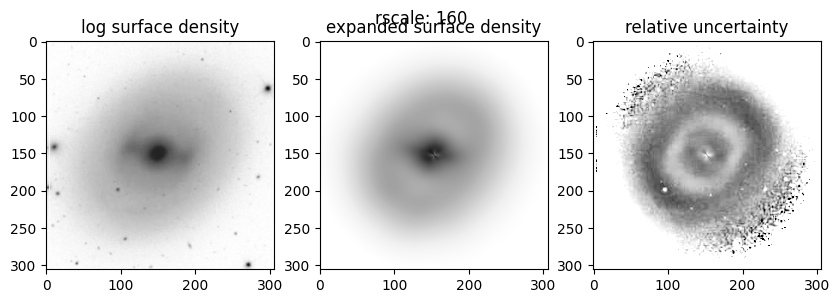

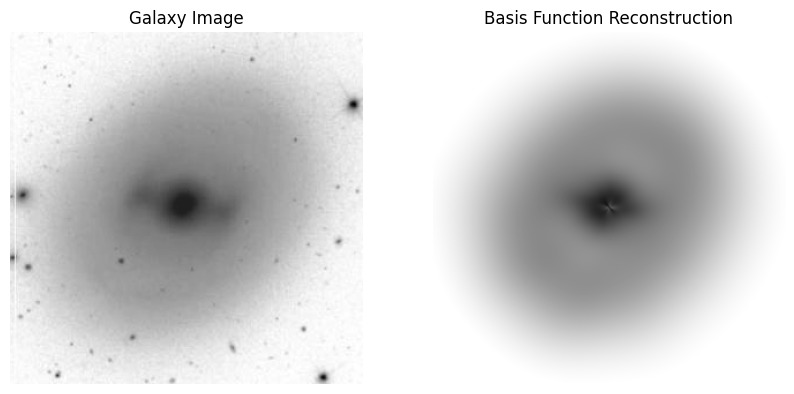

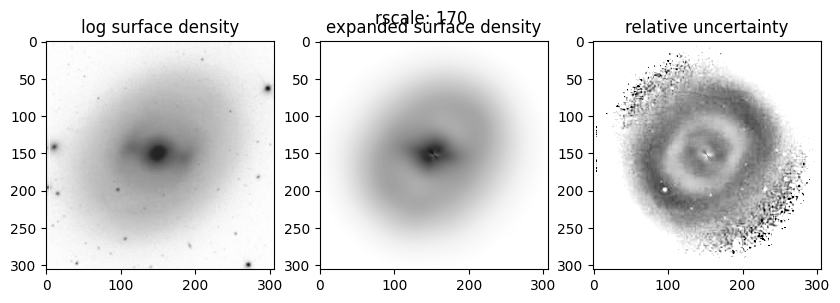

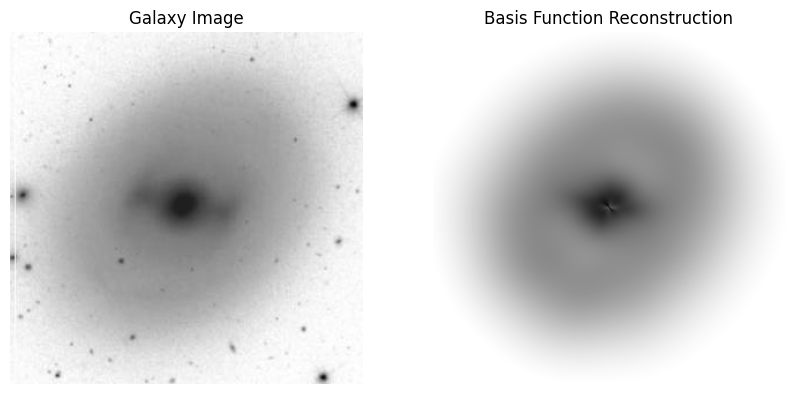

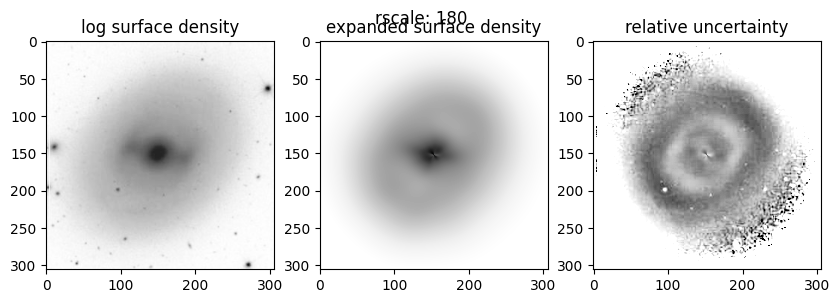

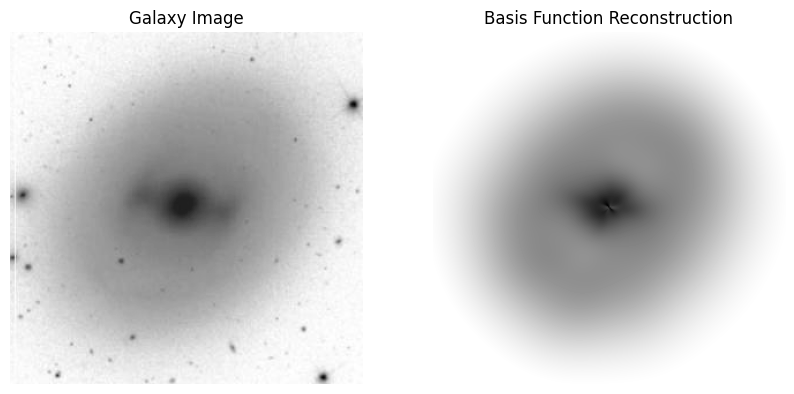

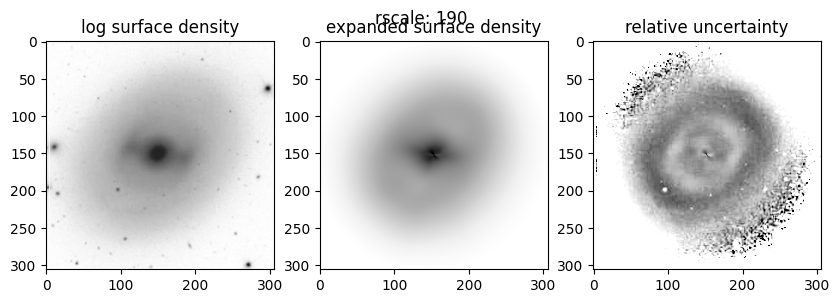

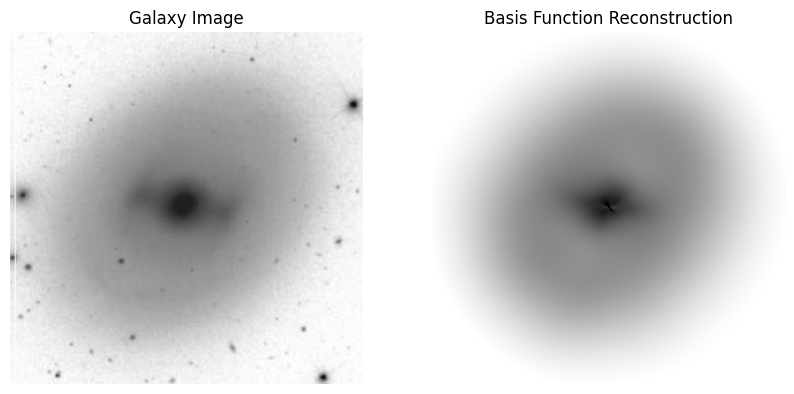

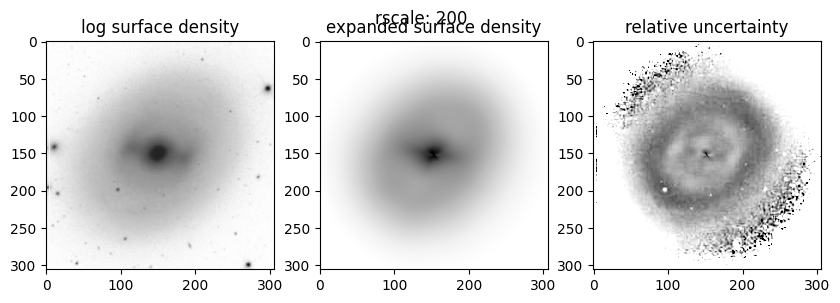

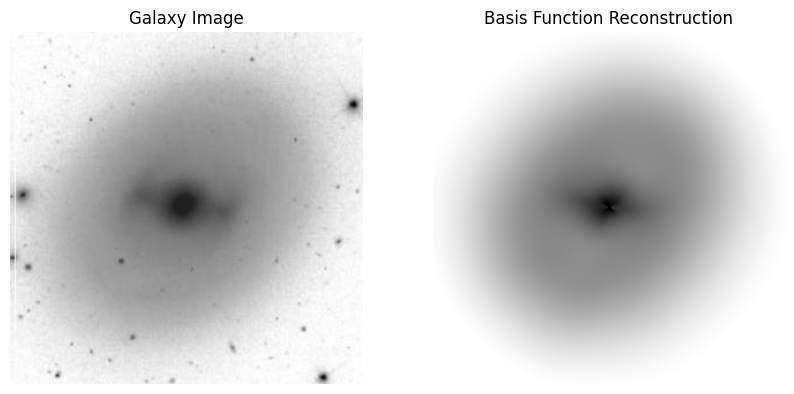

In [200]:
# construct the grid for the image
xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)

print(bar.shape, bar.max())
barflat = bar.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>130.)#140

rval[gvals]         = np.nan
phi[gvals]          = np.nan
#barflat[gvals] = np.nan
barflat = np.where(rval<130., barflat, np.NaN)
print(bar.shape, bar.max())
# pick orders for the expansion
mmax = 12#8
nmax = 36#24

# pick a scalelength for the reconstruction
#120, 140 p good
trial_rs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
for r in trial_rs:
    print('trying r scale of: ', r)
    rscl = r #95, 100
    
    # make the expansion and compute the weights
    LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,barflat)
    #c_bar, s_bar = LG.laguerre_amplitudes_returns()
    
    LG.laguerre_reconstruction(rr,pp)
    # make a figure for the comparison
    fig = plt.figure(figsize=(10,3),facecolor='white')
    fig.suptitle('rscale: '+str(r))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    cval = np.linspace(-5.,1.,32)
    ax1.imshow((bar),cmap=plt.cm.Greys)
    ax2.imshow(LG.reconstruction,vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.Greys)
    
    # plot the relative uncertainty (maxed out at 25 percent)
    ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25, vmax=.25,cmap=cm.Greys)
    
    ax1.set_title('log surface density')
    ax2.set_title('expanded surface density')
    ax3.set_title('relative uncertainty')
    
    
    import matplotlib.colors as colors
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(bar,cmap='binary')#,cmap='magma_r')
    ax2.imshow(LG.reconstruction,cmap='binary',vmin=np.nanmin(bar), vmax=np.nanmax(bar))
    ax1.set_title('Galaxy Image')
    ax2.set_title('Basis Function Reconstruction')
    
    ax1.axis('off')
    ax2.axis('off')
    print(LG.reconstruction.min(), LG.reconstruction.max(), bar.min(),bar.max())
    #rscale of 70, nmax = 12 mmax = 36 is p decent

(306, 306) 236.33333333333334
(306, 306) 236.33333333333334
-4.987171797687041 342.669227909112 0.3333333333333333 236.33333333333334
-4.997388277846885 341.0065269210603 0.3333333333333333 236.33333333333334
-5.094538875393658 389.7025160795046 0.3333333333333333 236.33333333333334
-5.024270702048585 391.627810246346 0.3333333333333333 236.33333333333334
-5.278331713953711 774.7231030917599 0.3333333333333333 236.33333333333334
-5.230524714645014 775.4989176932849 0.3333333333333333 236.33333333333334
-5.540476870063818 950.1874443052654 0.3333333333333333 236.33333333333334
-5.53249583873804 948.4317495604703 0.3333333333333333 236.33333333333334


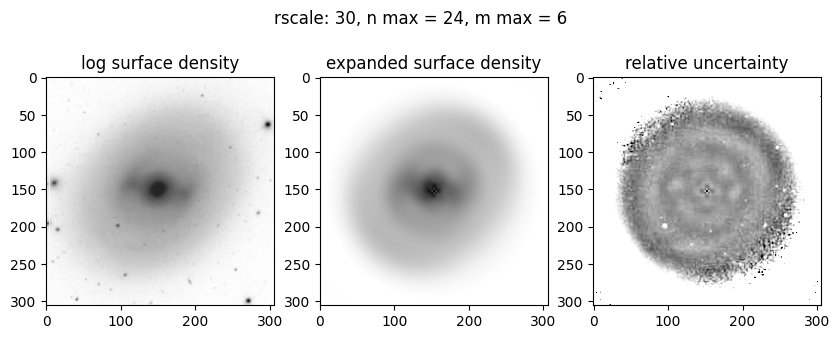

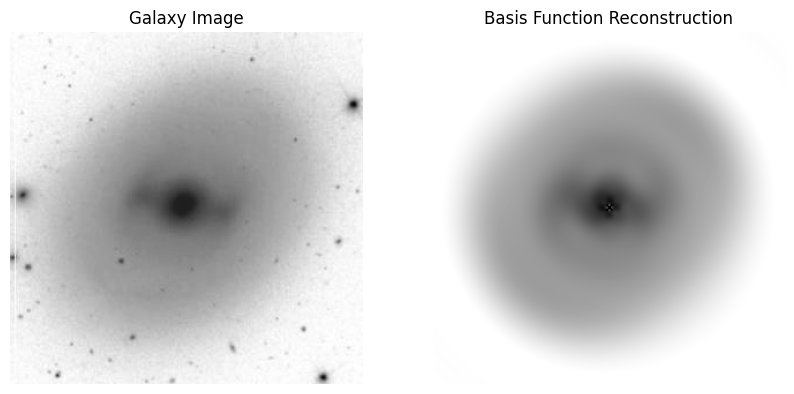

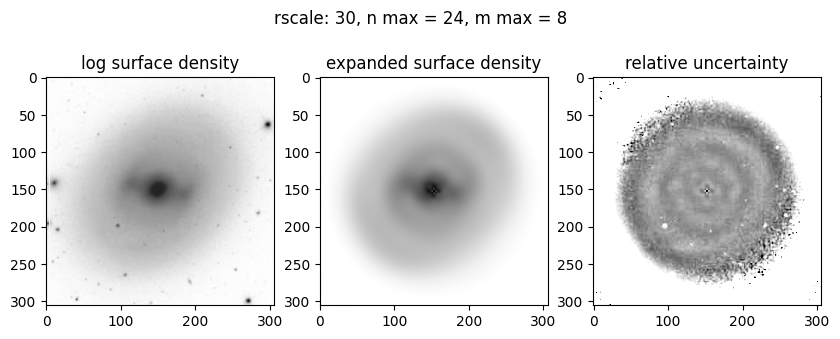

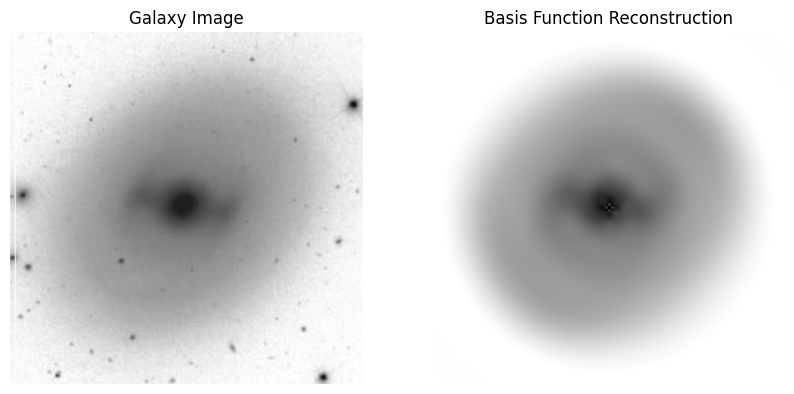

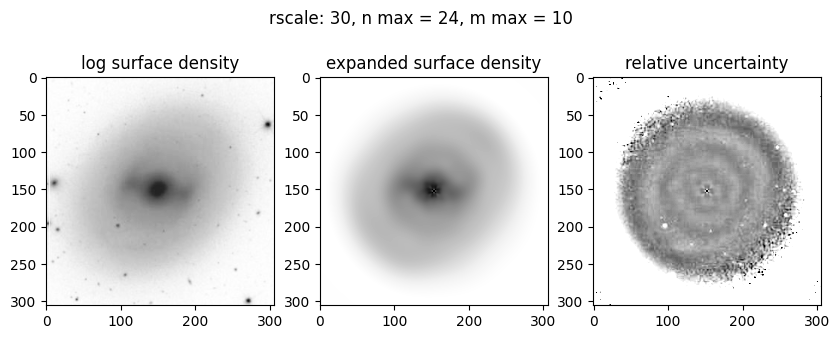

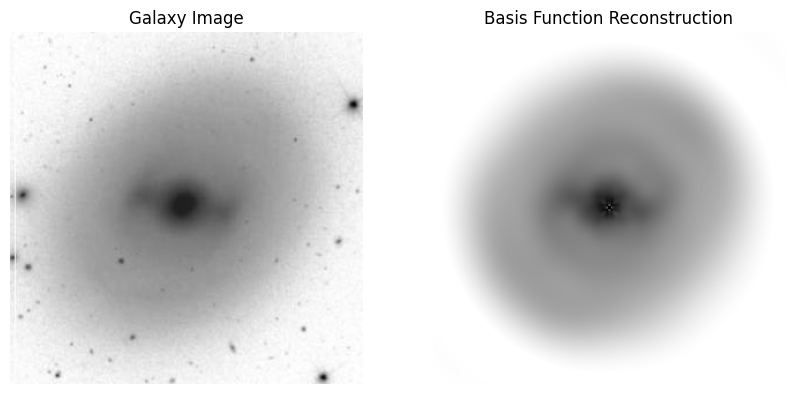

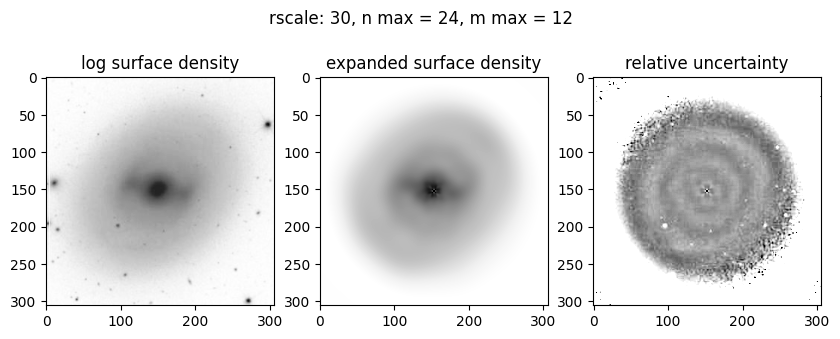

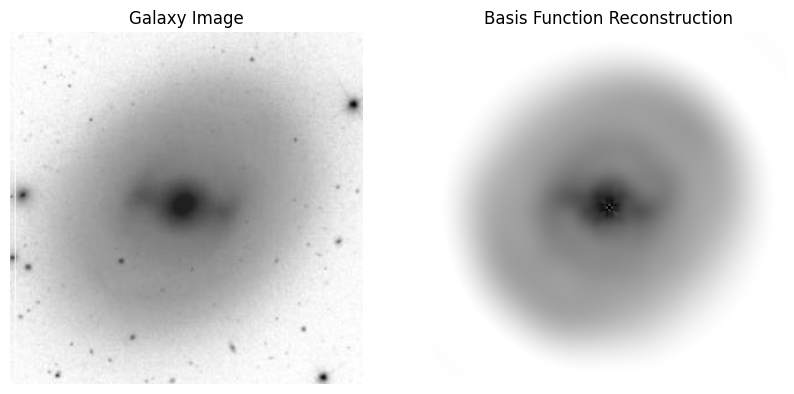

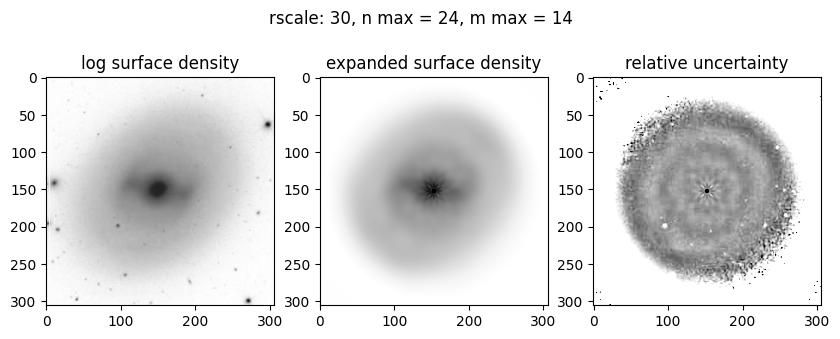

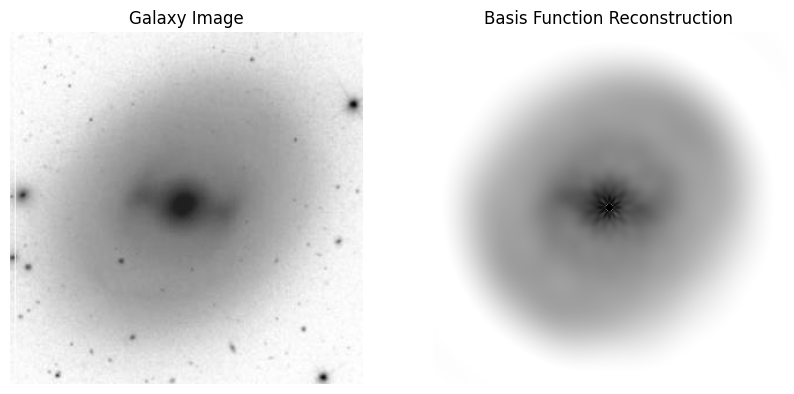

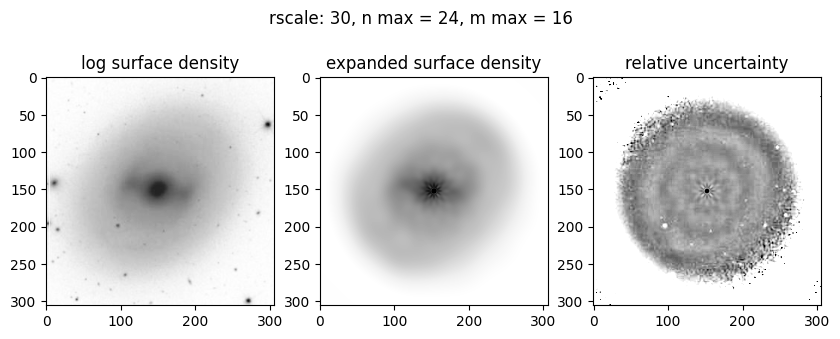

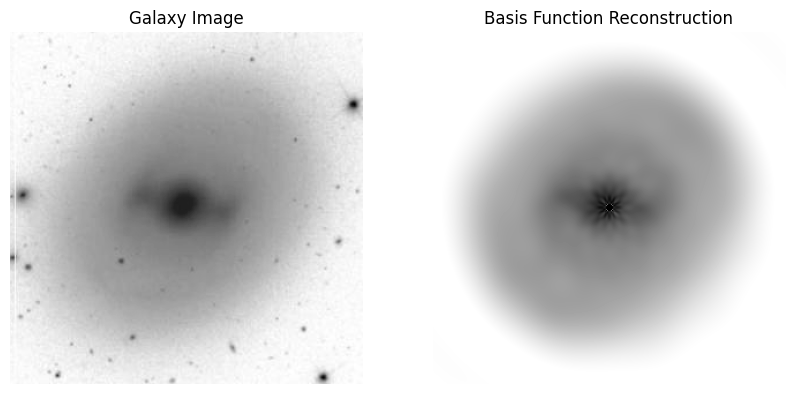

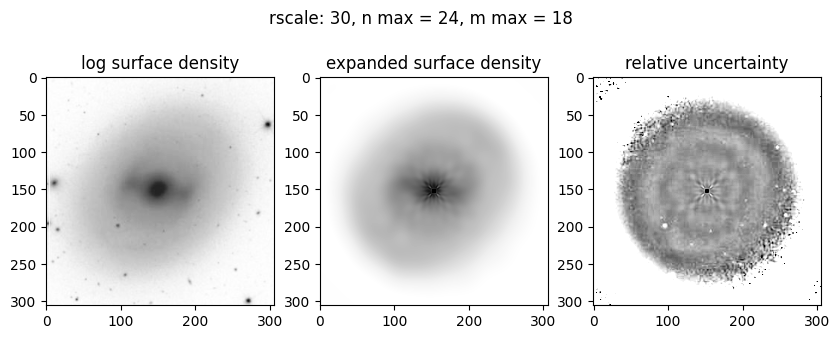

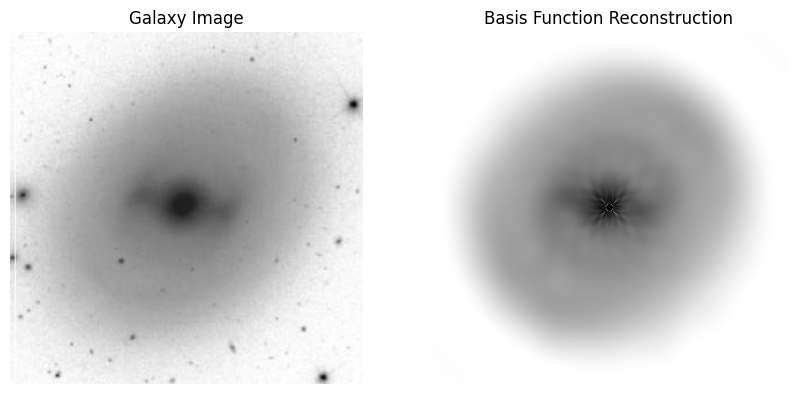

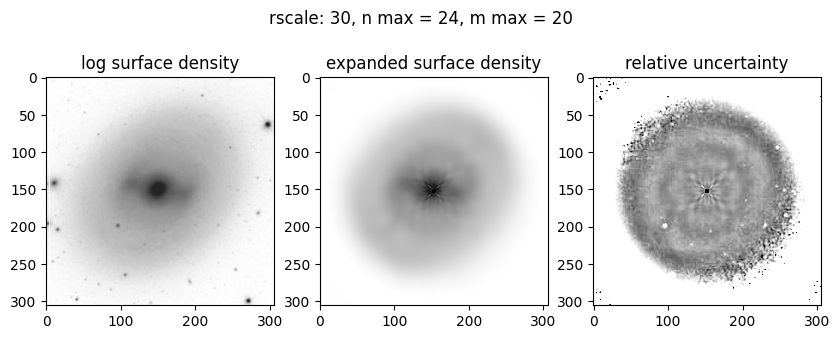

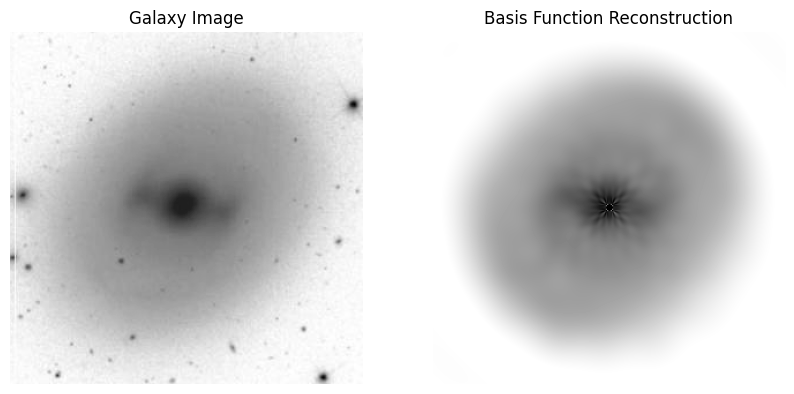

In [205]:
# construct the grid for the image
xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)

print(bar.shape, bar.max())
barflat = bar.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>130.)#140

rval[gvals]         = np.nan
phi[gvals]          = np.nan
#barflat[gvals] = np.nan
barflat = np.where(rval<130., barflat, np.NaN)
print(bar.shape, bar.max())
# pick orders for the expansion

# pick a scalelength for the reconstruction
#120, 140 p good
nmax = 24
rscl = 30 #95, 100
trial_ms = [6, 8, 10, 12, 14, 16, 18, 20]
for mmax in trial_ms:
    

    # make the expansion and compute the weights
    LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,barflat)
    #c_bar, s_bar = LG.laguerre_amplitudes_returns()
    
    LG.laguerre_reconstruction(rr,pp)
    # make a figure for the comparison
    fig = plt.figure(figsize=(10,3),facecolor='white')
    fig.suptitle('rscale: '+str(rscl) + ', n max = '+str(nmax) + ', m max = ' + str(mmax), y =1.1)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    cval = np.linspace(-5.,1.,32)
    ax1.imshow((bar),cmap=plt.cm.Greys)
    ax2.imshow(LG.reconstruction,vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.Greys)
    
    # plot the relative uncertainty (maxed out at 25 percent)
    ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25, vmax=.25,cmap=cm.Greys)
    
    ax1.set_title('log surface density')
    ax2.set_title('expanded surface density')
    ax3.set_title('relative uncertainty')
    
    
    import matplotlib.colors as colors
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(bar,cmap='binary')#,cmap='magma_r')
    ax2.imshow(LG.reconstruction,cmap='binary',vmin=np.nanmin(bar), vmax=np.nanmax(bar))
    ax1.set_title('Galaxy Image')
    ax2.set_title('Basis Function Reconstruction')
    
    ax1.axis('off')
    ax2.axis('off')
    print(LG.reconstruction.min(), LG.reconstruction.max(), bar.min(),bar.max())

(100.0, 200.0)

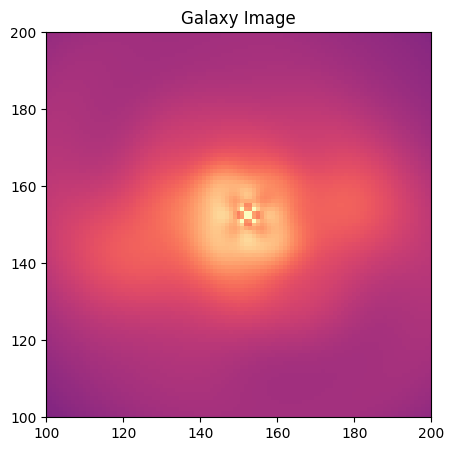

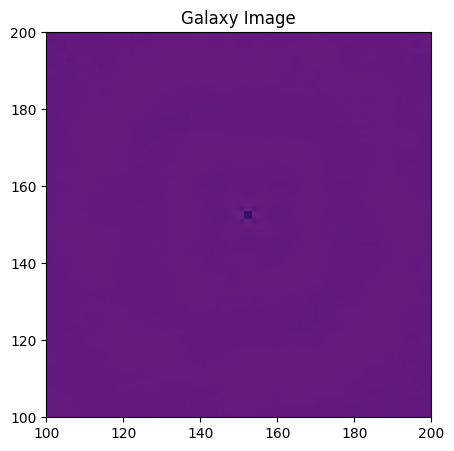

In [130]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax1.imshow(LG.reconstruction,cmap='magma',vmin=np.nanmin(bar), vmax=np.nanmax(bar))
ax1.set_title('Galaxy Image')
ax1.set_xlim(100,200)
ax1.set_ylim(100,200)

fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax1.imshow((bar-LG.reconstruction)/bar,cmap='magma')#,vmin=np.nanmin(bar), vmax=np.nanmax(bar))
ax1.set_title('Galaxy Image')
ax1.set_xlim(100,200)
ax1.set_ylim(100,200)

<class 'numpy.ndarray'>


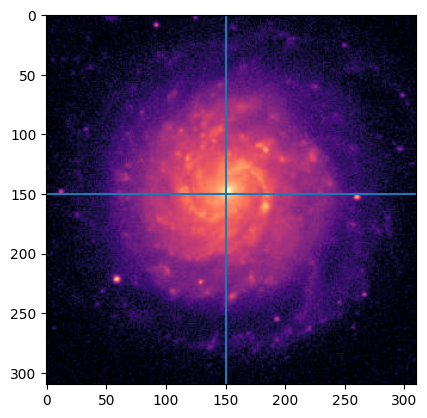

In [194]:
# loading in new figures
from PIL import Image
spiral = np.asarray(Image.open('spiral.jpeg'))
print(type(spiral))
spiral = np.mean(spiral, axis=2)
#bar = bar/bar.max()

plt.figure()
plt.imshow(spiral[10:,10:], cmap='magma') # not centered -
plt.axvline(150)#60)
plt.axhline(150)#60)

spiral = spiral[10:,10:]
#np.save('bar.npy', bar)

(310, 310) 208.33333333333334
(310, 310) 208.33333333333334
-3.919189667502184 342.61943750376787 0.0 208.33333333333334


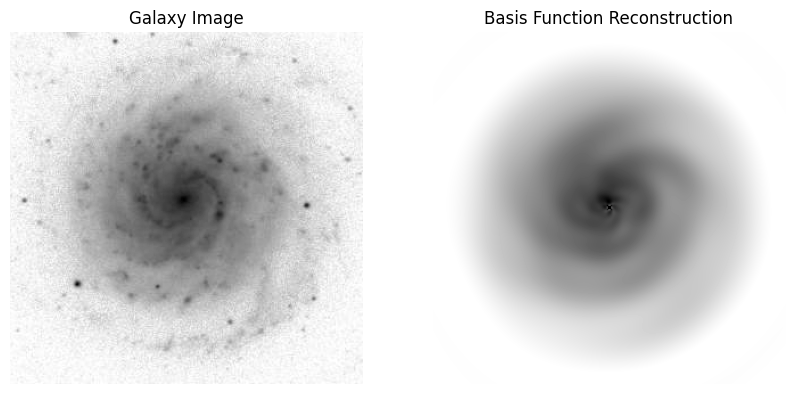

In [197]:
# construct the grid for the image
xp = np.linspace(-spiral.shape[0]/2.,spiral.shape[0]/2.,spiral.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)

print(spiral.shape, spiral.max())
spiralflat = spiral.reshape(-1,)

# pick a radius to not consider outside of
gvals = np.where(rval>130.)#140

rval[gvals]         = np.nan
phi[gvals]          = np.nan
#spiralflat[gvals] = np.nan
spiralflat = np.where(rval<130., spiralflat, np.NaN)
print(spiral.shape, spiral.max())
# pick orders for the expansion
mmax = 8#8
nmax = 24#24


rscl = 20 #95, 100
    
LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,spiralflat)
    
LG.laguerre_reconstruction(rr,pp)
import matplotlib.colors as colors
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(spiral,cmap='binary')#,cmap='magma_r')
ax2.imshow(LG.reconstruction,cmap='binary',vmin=np.nanmin(spiral), vmax=np.nanmax(spiral))
ax1.set_title('Galaxy Image')
ax2.set_title('Basis Function Reconstruction')
    
ax1.axis('off')
ax2.axis('off')
plt.savefig('spiral_recon_attempt.jpeg',bbox_inches = 'tight',
    pad_inches = 0) 
print(LG.reconstruction.min(), LG.reconstruction.max(), spiral.min(),spiral.max())
#     #rscale of 70, nmax = 12 mmax = 36 is p decent
# pick a scalelength for the reconstruction
# trial_rs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
# for r in trial_rs:
#     print('trying r scale of: ', r)
#     rscl = r #95, 100
    
#     # make the expansion and compute the weights
#     LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,spiralflat)
#     #c_spiral, s_spiral = LG.laguerre_amplitudes_returns()
    
#     LG.laguerre_reconstruction(rr,pp)
#     # make a figure for the comparison
#     fig = plt.figure(figsize=(10,3),facecolor='white')
#     fig.suptitle('rscale: '+str(r))
#     ax1 = fig.add_subplot(131)
#     ax2 = fig.add_subplot(132)
#     ax3 = fig.add_subplot(133)
    
#     cval = np.linspace(-5.,1.,32)
#     ax1.imshow((spiral),cmap=plt.cm.Greys)
#     ax2.imshow(LG.reconstruction,vmin=np.nanmin(spiral), vmax=np.nanmax(spiral),cmap=cm.Greys)
    
#     # plot the relative uncertainty (maxed out at 25 percent)
#     ax3.imshow((LG.reconstruction-spiral)/spiral,vmin=-.25, vmax=.25,cmap=cm.Greys)
    
#     ax1.set_title('log surface density')
#     ax2.set_title('expanded surface density')
#     ax3.set_title('relative uncertainty')
    
    
#     import matplotlib.colors as colors
    
#     fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
#     ax1.imshow(spiral,cmap='binary')#,cmap='magma_r')
#     ax2.imshow(LG.reconstruction,cmap='binary',vmin=np.nanmin(spiral), vmax=np.nanmax(spiral))
#     ax1.set_title('Galaxy Image')
#     ax2.set_title('Basis Function Reconstruction')
    
#     ax1.axis('off')
#     ax2.axis('off')
#     print(LG.reconstruction.min(), LG.reconstruction.max(), spiral.min(),spiral.max())
#     #rscale of 70, nmax = 12 mmax = 36 is p decent

/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_44048/864768934.py:9: RuntimeWarning: invalid value encountered in log10
  ax2.contourf(xpix,ypix,np.log10(LG.reconstruction),cval,cmap=cm.Greys)


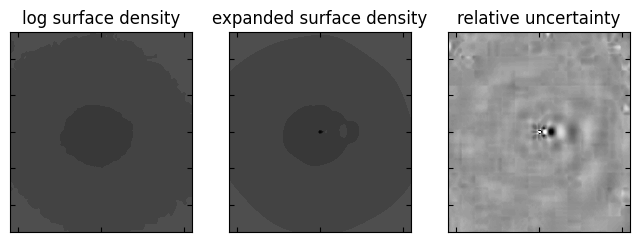

In [16]:
# make a figure for the comparison
fig = plt.figure(figsize=(8,2.6),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.contourf(xpix,ypix,np.log10(bar), cval,cmap=plt.cm.Greys)
ax2.contourf(xpix,ypix,np.log10(LG.reconstruction),cval,cmap=cm.Greys)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.contourf(xpix,ypix,(LG.reconstruction-bar)/bar,np.linspace(-.25,.25,100),cmap=cm.Greys)

ax1.set_title('log surface density')
ax2.set_title('expanded surface density')
ax3.set_title('relative uncertainty')

for ax in [ax1,ax2,ax3]:
    ax.axis([-55,55,-55,55])
    ax.set_xticklabels(())
    ax.set_yticklabels(())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

In [86]:
arr = np.array([[1,2,3,4], [55,6,7,8]])
arr.shape
arr2 = arr.reshape(-1,)
masky = np.ones_like(arr2)
print(arr, 'now arr2', arr2, 'shape', arr2.shape, 'masy shape', masky.shape)
masku = np.where(masky > 0.)
print(masky, masku)
arr2[masku] = np.NaN
#arr

[[ 1  2  3  4]
 [55  6  7  8]] now arr2 [ 1  2  3  4 55  6  7  8] shape (8,) masy shape (8,)
[1 1 1 1 1 1 1 1] (array([0, 1, 2, 3, 4, 5, 6, 7]),)


array([ 1,  2,  3,  4, 55,  6,  7,  8])

In [67]:
arr2[0] = np.NaN

ValueError: cannot convert float NaN to integer

In [98]:
# pick a radius to not consider outside of
# construct the grid for the image
xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)



rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)

print(bar.shape, bar.max())
barflat = bar.copy().reshape(-1,)
print(barflat.shape)
# pick a radius to not consider outside of
gvals = np.where(rval>140.)#140
print(gvals[0].shape)
print(barflat[gvals].shape)
barflat[gvals] = 1

(307, 307) 1.0
(94249,)
(33052,)
(33052,)
